 # Particle Swarm Optimization
 
 In this notebook I would like to show [Particle Swarm Optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization) technique.
 
 I will be using BBOX (Black-Box-Optimization-Benchmarking) function from [COCO](https://coco.gforge.inria.fr/) (COmparing Continuous Optimisers) framework. This frameworks contains 24 parametrized functions (value and position of optimum can be random every evaluation) and the goal of the algorithm is to find minimum in the specified region. Different functions tests different aspects of the algorithm and contains easy to optimize function using simple gradient descent algorithm (function `f01`) as well as asymetric functions (function `f06`) and functions with many local optima (function `f16`). You can find more informations about the individual function in the official [bbobdocfunctions.pdf](http://coco.lri.fr/downloads/download15.02/bbobdocfunctions.pdf) (note that functions in this documents are flip and the task is to maximize them).
 
 I don't want to show only the traditional Particle Swarm Optimization algorithm, but rather evolution of the idea and it improvements. As so, I will start with the simple strategies like gradient descent or random movement and I will incrementally improve this ideas to achieve better results. I will discuss every new idea and compare it to the previous results, so you can see how it change the behavior of the algorithm and how big impact it has on the performance of the algorithm.
 
 Moreover, I implemented different helper methods to execute the strategies and plot the results. In my opinion picture shows more than just numbers. I will try to plot every result that is interesting (that I believe is interesting) so you can really see what is happening inside.

## Code description

Before we dive into the algorithm itsjelf, I want to describe how this repository is implemented so you can try your experiments on your own. First thing you need to have is the COCO framework, that you can download here: [https://github.com/numbbo/coco](https://github.com/numbbo/coco). Unfortunatelly, the framework is written in C and as such needs to be compiled. All the instructions are in the COCO's repository. As far as I know, there is no simple way as `pip install` command.

First of all, I will enable interactive shell. I wanted to show gifs of particles movement over the generations, however, these gifs are quiet a huge files (around 25MB per 100 generations) so I decided not to include them in this notebook. You can enable it on your machine by setting `SHOW_GIFS` variable to `True`. I also export this notebook (including the gifs) to this website: (TODO soon). 

**Warning: generating gifs takes a significant amount of time as well.**

In [3]:
%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

SHOW_GIFS = False

Now let's import all the libraries. File `functions.py` contains helper functions to import the BBOB functions, `execution.py` than executes the strategies and `plotting.py` contains helper methods for plotting the results, I will discuss it a little bit later.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import cocoex
import functools
import functions as fn
import execution as exe
import plotting as plot
import inspect
import strategies
import utils

We may now define our first strategy. Let's start with the simple numeric gradient descent approach. Strategy accepts three parameters: particles, their values and function to optimize.

I implemented gradient computation using helper method in file `utils.py` that computes the gradient of the function by the following formula.
$$
\nabla f(x)_i = \frac{f\left( x_i - gradient\_step \right) - f\left( x_i + gradient\_step \right)}{2 \cdot gradient\_step}
$$

I want to use strategies in multiple notebooks and as such I can't define them in the notebook itself (or I could but that would complicating rest of the notebooks). I therefore decided to define all the strategies in `strategies.py` file and just import it. I still wanted to show you the source code, so I used `inspection` module to obtain source code and then let Markdown render it. I understand this is not the ideal state, but it's the best I think of.

In [3]:
definition = inspect.getsource(strategies.numeric_gradient_descent)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
def numeric_gradient_descent(
        particles: np.ndarray,
        values: np.ndarray,
        function: cocoex.Problem,
        gradient_step: float,
        computation_step: float) -> np.ndarray:
    gradients = utils.compute_gradient(function, particles, gradient_step)
    return particles - gradients * computation_step

```

Now it is required to load the functions. It can be done using `fn.get_suite`. You can pass two parameters - how many dimensions should the functions have and which functions to load. The functions can be obtained by iterationg over suite or by calling `get_problem(problem_id)` method. For now I will work with two dimensional function `f01`.

In [4]:
suite = fn.get_suite(dimension=[2], function_indices=[1])
function = suite.get_problem(0)

I will apply the `numeric_gradient_descent` strategy on that function using `exe.execute` call. You can specify additional parameters - their purpose should be clear from it's name and doc string. The function returns **history** of population and their values.

In [5]:
populations, evaluations = exe.execute(
    function=function,
    algorithm=functools.partial(strategies.numeric_gradient_descent, gradient_step=1e-6, computation_step=0.02),
    population_size=10,
    generations=100,
    initialization=np.random.uniform,
    show_progress=True
)

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


## Plotting population 

Now, when I have population and particles values, I will plot how the population looked like at the beginning and in the end. The `populations` has shape `(generations, population_size, dimension)`. I implemented `plot.plot_population` function that accepts function to optimize and single population.

**This and all the following functions works only on two dimensional space.**

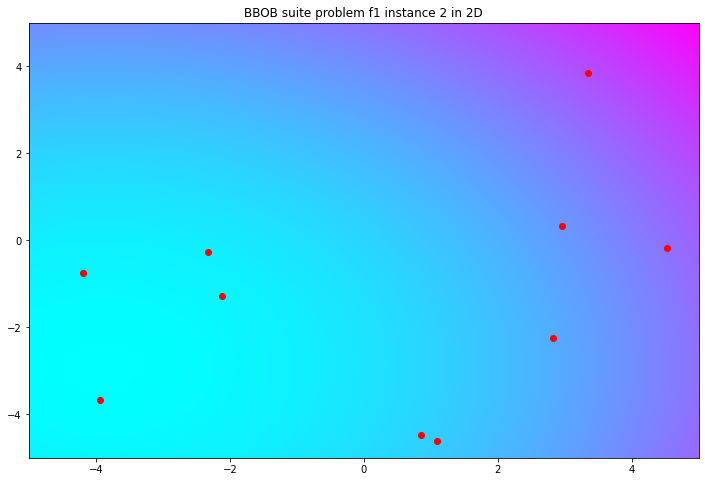

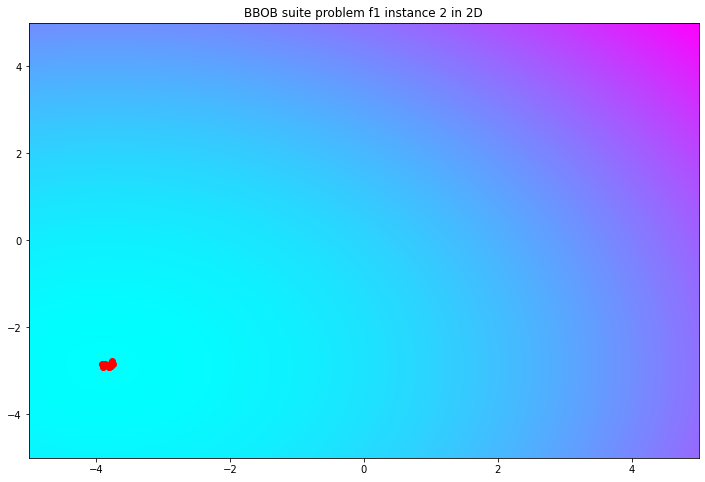

In [6]:
plot.plot_population(function, populations[0])
plot.plot_population(function, populations[-1])

Moreover, if you are interested in movement of individual, you may use `plot.plot_movenemt_of_individual` that accepts function and single member of shape `(generations, dimension)`.

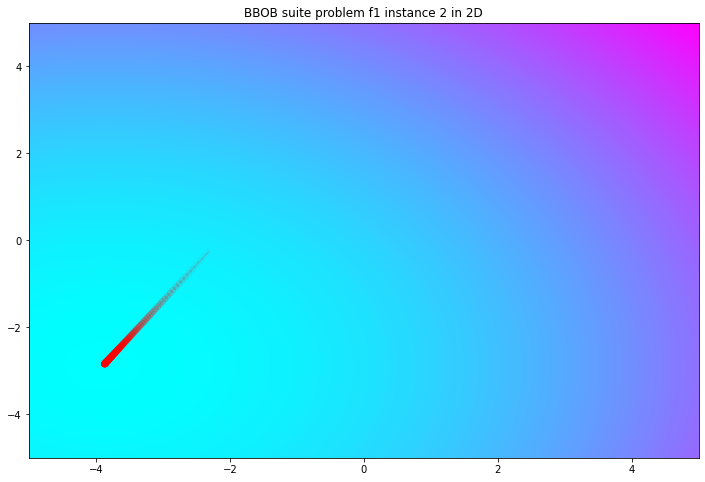

In [7]:
plot.plot_movement_of_individual(function, populations[:,3,:], line_alpha=0.15)

Finally, it is possible to plot movement of the whole population using `plot.animate_movement`. As I already mentioned, generated gifs are around 25MB per 100 generations, so I decided not to include them in this notebook. You can download this notebook and after changing the `SHOW_GIFS` variable to True the gifs should be generated. Alternativelly, you can view following site, where I exported notebook to HTML: (TODO)

In [8]:
if SHOW_GIFS:
    gif = plot.animate_movement(function, populations, figsize=(12,8))
    display.Image(data=gif, format='png')

Before I move on to the plotting of fitness, note that the COCO framework is written in C and as such it needs to release the resources. You should call `free` method on the suite object. I implemented a small wrapper that automatically close the suite after use, however, in that case, you can't use the `function` afterward.

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


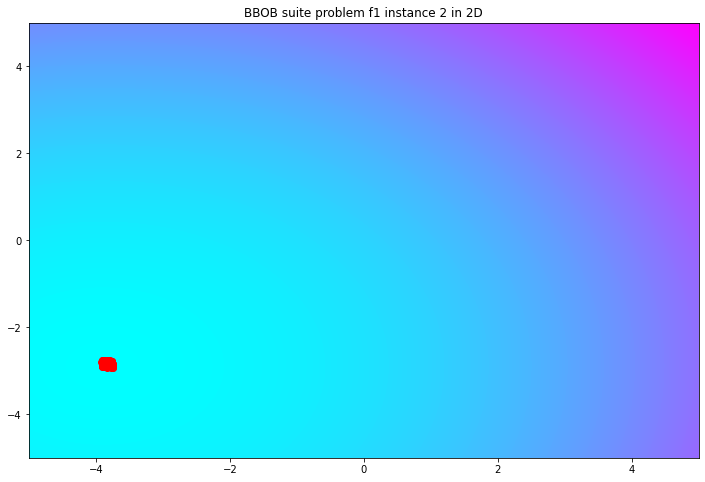

In [9]:
# free the suite
suite.free()

# use wrapper
with fn.get_suite_wrapper(dimension=[2], function_indices=[1]) as suite:
    for function in suite:
        populations, evaluations = exe.execute(
            function,
            functools.partial(strategies.numeric_gradient_descent, gradient_step=1e-6, computation_step=0.02),
            show_progress=True
        )
        
        plot.plot_population(function, populations[-1])
# can't be here, as `function` is already freed
#plot.plot_population(function, populations[0])

# Plotting fitness

I shown how to plot the population, but there is no other reason to use it except to see how the algorithm behaves in 2D space. I will now focus on plotting the fitnesses (in other word how good the algorithms are). 

Note that the `exe.execute` function returns not only the population, but the fitnesses of the algorithm in the variable `evaluations`. This variable has shape `(generations, population_size)` so we need to somehow reduce it to shape `(generations)` in order to use line plot. I implemented function `plot.plot_graph` that accepts fitnesses, function that reduce fitnesses into 1D array and keyword arguments, that will be passed into `matplotlib.plot` call.

Note that this function doesn't call `matplotlib.show` implicitly, so you can call this function multiple times and stack the plots.


I will now plot mean and median fitness in each generation.

*The semicolon at the end of the line supress the output.*

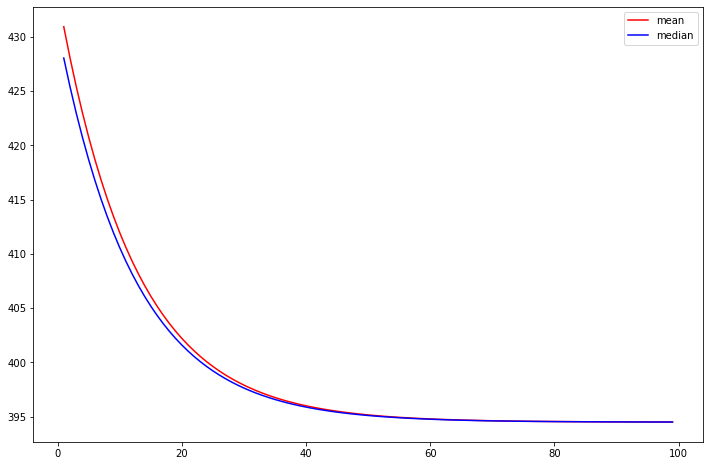

In [10]:
plt.figure(figsize=(12,8))
plot.plot_graph(
    evaluations,
    lambda fitnesses: np.mean(fitnesses, axis=1),
    color='r',
    label='mean'
)
plot.plot_graph(
    evaluations,
    lambda fitnesses: np.quantile(fitnesses, q=0.5, axis=1),
    color='b',
    label='median'
)
plt.legend();
plt.show();

It would be tedeous to write that lambda every time, so I implemented some helper functions `plot.popfn_*` that do that for me. Previous example would change to:

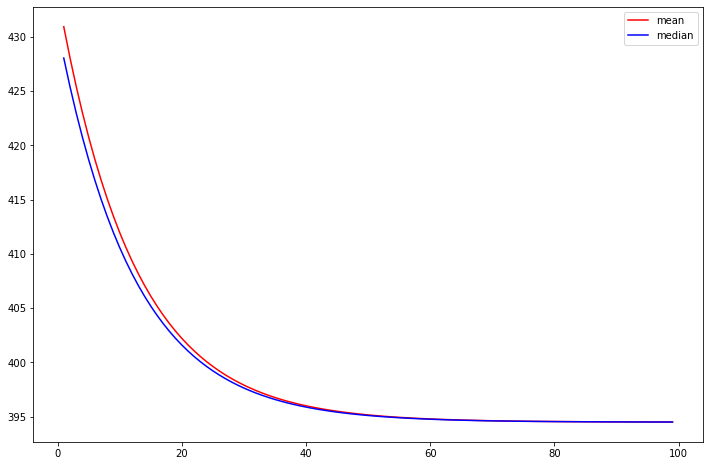

In [11]:
plt.figure(figsize=(12,8))
plot.plot_graph(
    evaluations,
    plot.popfn_mean(),
    color='r',
    label='mean'
)
plot.plot_graph(
    evaluations,
    plot.popfn_median(),
    color='b',
    label='median'
)
plt.legend();
plt.show();

## Repeated runs

Results of most algorithms I am going to discuss are based on randomness of some kind. Some runs may be extremly successfull and other can get stuck in the local optima. It is therefore statistically good idea to run same algorithm multiple times to better measure the performance of the algorithms. I implemented `exe.execute_multiple` function that accepts same arguments as `exe.execute` function plus `repeats` parameter. The resulting populations and fitnesses will be stacked from all the runs.

100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


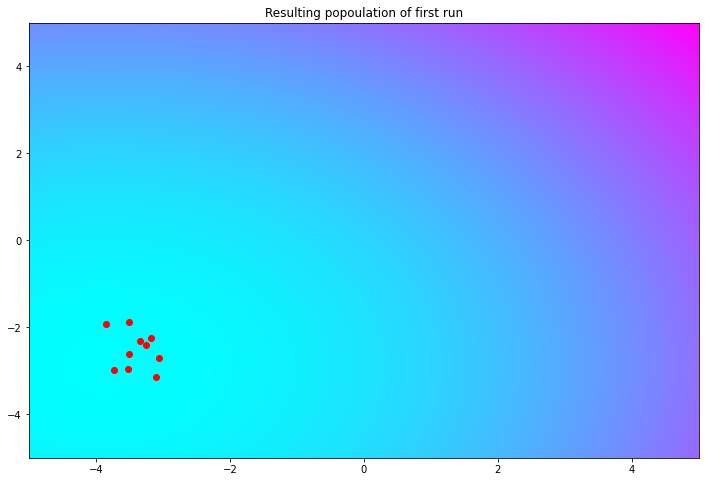

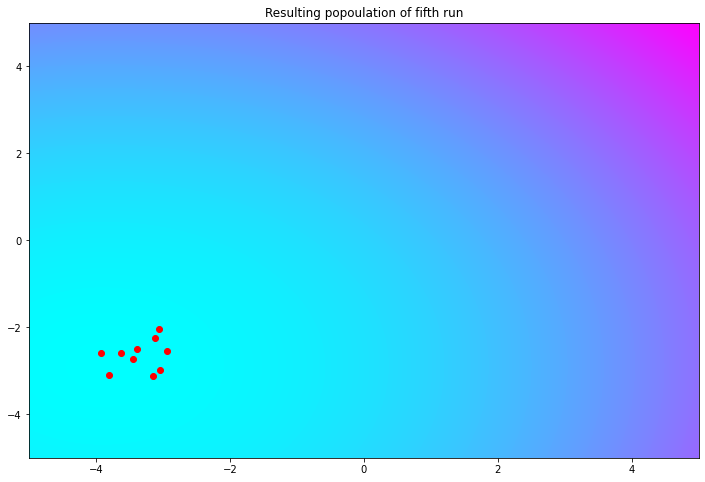

In [12]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[1]) as suite:
    for function in suite:
        populations, evaluations = exe.execute_multiple(
            function,
            functools.partial(strategies.numeric_gradient_descent, gradient_step=1e-6, computation_step=0.01),
            population_size=10,
            show_progress=True,
            repeats=100
        )
        
        plot.plot_population(function, populations[0,-1], title="Resulting popoulation of first run")        
        plot.plot_population(function, populations[4,-1], title="Resulting popoulation of fifth run")        

In order to generate fitness plots, we need to aggregate data from all runs as well. I implemented function `plot.plot_aggregated` that accepts fitnesses, function to aggregate population (same as in the previous case), function to aggregate runs and parameters passed to `matplotlib.plot` function.

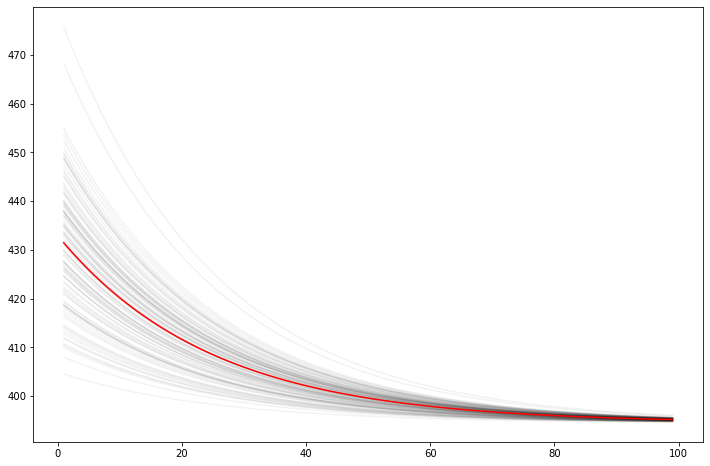

In [13]:
plt.figure(figsize=(12,8))
for evaluation in evaluations:
    plot.plot_graph(evaluation, plot.popfn_median(), color='black', alpha=0.05)
    
plot.plot_aggregated(
    evaluations, 
    plot.popfn_median(), 
    lambda v: np.median(v, axis=0),
    color='red'
)
plt.show();

Similar to `plot.popfn_*` functions there are `plot.aggfn_*` functions that do this aggregation.

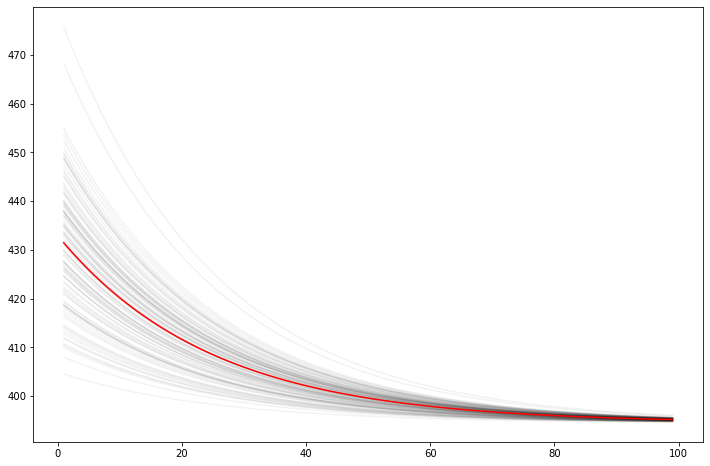

In [14]:
plt.figure(figsize=(12,8))
for evaluation in evaluations:
    plot.plot_graph(evaluation, plot.popfn_median(), color='black', alpha=0.05)
plot.plot_aggregated(
    evaluations, 
    plot.popfn_median(), 
    plot.aggfn_median(),
    color='red'
)
plt.show();

## Using custom class for population

So far I used `np.ndarray` representation of the population. In some algorithms, I will need to store additional informations. To do that, I will use custom class and `exe.execute` will handle it without any problems. All what is required is to provide `numpy()` method that returns coordinates of particles as numpy array and custom initialization. Just be sure you don't modify the population from the previous generation.

Let's take the most simple strategy and make only random steps.

In [15]:
definition = inspect.getsource(strategies.RandomWalkObject)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class RandomWalkObject:
    def __init__(self, lowerbound: np.ndarray, upperbound: np.ndarray, shape):
        self.population = np.random.uniform(lowerbound, upperbound, shape)
        self.lowerbound = lowerbound
        self.upperbound = upperbound

    def numpy(self):
        return self.population

    def execute(self, values: np.ndarray, function: cocoex.Problem):
        self.population = self.population + np.random.normal(0, 0.1, self.population.shape)
        self.population = np.maximum(self.lowerbound, np.minimum(self.upperbound, self.population))
        return self

    @staticmethod
    def initialize(lowerbound: np.ndarray, upperbound: np.ndarray, shape:tuple):
        return RandomWalkObject(lowerbound, upperbound, shape)

```

We may then call the `exe.execute` function the same way.

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


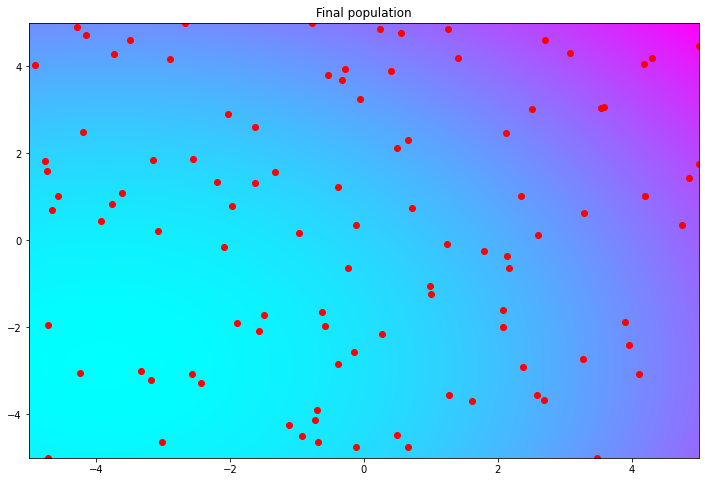

<Figure size 864x576 with 0 Axes>

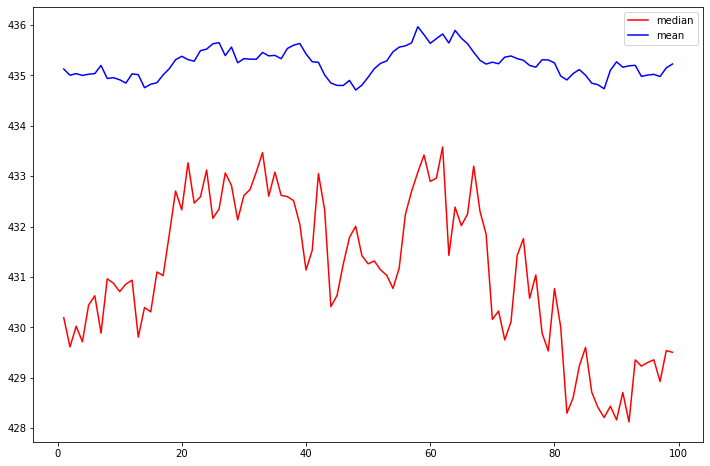

In [16]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[1]) as suite:
    for function in suite:
        populations, evaluations = exe.execute(
            function,
            strategies.RandomWalkObject.execute,
            initialization=strategies.RandomWalkObject.initialize,
            show_progress=True
        )
        
        plot.plot_population(function, populations[-1], title="Final population")
        
        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations, figsize=(12,8))
            display.Image(data=gif, format='png')
            
        
        plt.figure(figsize=(12,8))
        plot.plot_graph(evaluations, plot.popfn_median(), color='r', label="median")
        plot.plot_graph(evaluations, plot.popfn_mean(), color='b', label="mean")
        plt.legend()
        plt.show()